In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
import itertools
import matplotlib.patches as patches
import glob
from mphelper import ProcessWrapPool
import tempfile
import subprocess
from biodata.delimited import DelimitedWriter, DelimitedReader
from collections import defaultdict, Counter
import sys
from pathlib import Path
from biodatatools.utils.common import json_load

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_d2 = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Evo metrics

In [5]:
# Since it's union set of elements, it's easier just to anchor on element center; no need to flip sides

def intersect(fa, fb, outputfile, extension=500):
	with tempfile.NamedTemporaryFile(delete=False, suffix='.bed') as tmp:
		with DelimitedWriter(tmp.name) as dw, DelimitedReader(fa) as dr:
			for cols in dr:
				chrom, start, end = cols[:3]
				center = (int(start)+int(end))//2
				dw.write([chrom, center-extension, center+extension+1, start, end])
		fa = tmp.name
	cmd = f"bedtools intersect -a {fa} -b {fb} -wao > {outputfile}"
	subprocess.run(cmd, shell=True)

In [6]:
fb = " ".join(glob.glob(f"{PROJECT_DIR_d}UCSC/multiz100way/hg38/chr*.bed"))

In [9]:
p = "divergent"
ds = ["distal", "proximal"]

In [12]:
pwpool = ProcessWrapPool(len(ds))

for d in ds:
	fa = f"{PROJECT_DIR_d2}PROcap/processed/merged_{p}_{d}.bed.bgz"
	outputfile = f"{PROJECT_DIR_o}temp/{p}_{d}_age.bed"
	pwpool.run(intersect, args=[fa, fb, outputfile])

In [14]:
len(pwpool.finished_tasks)

2

In [15]:
pwpool.close()

In [11]:
# Check the output

inputfile = f"{PROJECT_DIR_o}temp/{p}_{d}_age.bed"
pd.read_table(inputfile, header=None, low_memory=False).head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,chr1,180803,181804,181113,181493,1,chr1,180672,180904,Primate,101
1,chr1,180803,181804,181113,181493,1,chr1,180904,181581,Homo_sapiens,677


In [12]:
clades = json_load(f"{PROJECT_DIR_r}other/age/clades.json")

In [13]:
df_features = {}

In [14]:
m = "Age"
for d in ds:
    inputfile = f"{PROJECT_DIR_o}temp/{p}_{d}_age.bed"
    df_features[(m,p,d)] = utils.age_dissection(inputfile, clades)

In [15]:
bws = {"phyloP": f"{PROJECT_DIR_d}UCSC/phyloP/hg38/hg38.phyloP447way.bw",
       "CDTS": f"{PROJECT_DIR_r}other/CDTS/coord_CDTS_percentile_N7794unrelated.bw"
        }

In [16]:
use_strand = False
for d in ds:
    bed = f"{PROJECT_DIR_d2}PROcap/processed/merged_{p}_{d}.bed.bgz"
    all_regions = BEDXReader.read_all(GenomicCollection, bed)
    index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
    for m in bws:
        df_features[(m,p,d)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

# Specificity score quantiles

In [22]:
# Quantiles

qs = 4
labels = [f"Q{n}" for n in range(1,qs+1)]
scores = {}
df_scores = {}
for d in ds:
	df_scores[(p,d)] = pd.read_table(f"{PROJECT_DIR_d2}PROcap/processed/specificity_{p}_{d}.txt", index_col=0)
	df_scores[(p,d)]["Bin"] = pd.qcut(df_scores[(p,d)]["Specificity"], q=qs, labels=labels)
	scores.update(df_scores[(p,d)]["Bin"].to_dict())

In [23]:
df_reformat = {}
for m, p, d in df_features:
	es = set(df_scores[(p,d)].index)
	df = df_features[(m,p,d)].loc[[e for e in list(df_features[(m,p,d)].index) if e in es]].reset_index()
	df_reformat[(m,p,d)] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

In [24]:
df_metaplots = {}
for k in df_reformat:
	df_metaplots[k] = df_reformat[k].copy()
	df_metaplots[k]["Label"] = df_metaplots[k]["index"].map(scores)

In [25]:
ms = ["Age", "phyloP", "CDTS"]

In [26]:
for m, d in itertools.product(ms, ds):
	maxs = []
	mins = []
	df = df_metaplots[(m,p,d)]
	for label in labels:
		maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
	print(m, p, d, max(maxs), min(mins))

Age divergent distal 227.23266244968372 162.1738322862606
Age divergent proximal 379.23463244613436 247.80596444274516
phyloP divergent distal 0.47685951009528493 -0.0554965962661082
phyloP divergent proximal 0.7386889978788934 0.08324402811672356
CDTS divergent distal -0.6956557308653029 -2.593721501831478
CDTS divergent proximal -2.353541589732178 -9.759791662063902


In [44]:
def generate_metaplot(df_metaplots, ylims, yticks, test, outputfile, hue_order, palette, figsize, legend=True):
	fig, axes = plt.subplots(len(ms), len(ds), figsize=figsize)
	
	for m, d in itertools.product(ms, ds):
		col = ds.index(d)
		row = ms.index(m)
		ax = axes[row, col]

		utils.generate_feature_metaplot(df_metaplots[(m,p,d)], palette, hue_order, ax, test, None)

		if row == 0:
			ax.set_title(d.capitalize(), fontsize=bfontsize)
		else:
			ax.set_title("")
			
		if col == 0:
			ax.set_ylabel(m, fontsize=bfontsize)
		else:
			ax.set_ylabel("")
		ax.get_yaxis().set_label_coords(-0.4, 0.5)
		ax.set_ylim(ylims[d][ms.index(m)])
		ax.set_yticks(yticks[d][ms.index(m)])

		xtick_list = [0, 500, 1000]
		xticklabel_list = ["-0.5", "0", "0.5"]
		ax.set_xlim([0, 1000])
		ax.set_xticks(xtick_list)
		if row == len(ms)-1:
			ax.set_xticklabels(xticklabel_list)
			ax.set_xlabel("Distance (kb)", fontsize=bfontsize)
		else:
			ax.set_xticklabels([])
			ax.set_xlabel("")
			
		ax.tick_params(labelsize=sfontsize)

		if legend:
			if row == 0 and col == 0:
				ax.legend(loc="center", bbox_to_anchor=(1.1,1.4), fontsize=sfontsize, frameon=False, ncol=4)
			else:
				ax.legend([],[], frameon=False)
		else:
			ax.legend([],[], frameon=False)

	if legend:
		fig.text(axes[0,0].get_position().x0, 1.05, "Ubiquitous", va="center", ha="center",
				fontsize=sfontsize, color="#969696")
		fig.text(axes[0,1].get_position().x1, 1.05, "Exclusive", va="center", ha="center",
				fontsize=sfontsize, color="#969696")
		arrow = patches.FancyArrowPatch(
			(axes[0,0].get_position().x0, 1.02),
			(axes[0,1].get_position().x1, 1.02),
			arrowstyle='<->',        
			mutation_scale=10, 
			linewidth=1,
			clip_on=False,
			transform=fig.transFigure,
			color="#969696"       
		)
		ax.add_patch(arrow)

	fig.subplots_adjust(wspace=0.4, hspace=0.3)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

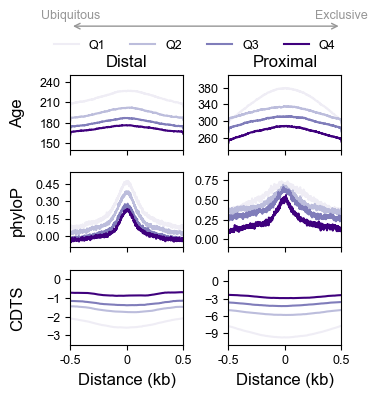

In [47]:
# test = True
test = False
hue_order = [f"Q{n}" for n in range(1,qs+1)]
palette = ["#efedf5", "#bcbddc", "#807dba", "#3f007d"]
ylims = {"distal": [[140, 250], [-0.1, 0.55], [-3.5, 0.5]],
		 "proximal": [[230, 410], [-0.1, 0.85], [-11, 2]]
		}
yticks = {"distal": [[150, 180, 210, 240], [0, 0.15, 0.3, 0.45], [-3, -2, -1, 0]],
		  "proximal": [[260, 300, 340, 380], [0, 0.25, 0.5, 0.75], [-9, -6, -3, 0]]
		 }
outputfile = f"{PROJECT_DIR_o2}figures/Fig3c.pdf"
generate_metaplot(df_metaplots, ylims, yticks, test, outputfile, hue_order, palette, (3.5,3.5))

# Tissue-specific elements

In [37]:
cdict = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/color_codes.json")
ts = list(cdict)

In [49]:
cutoff = 0.05
tres = defaultdict(dict)
for d, t in itertools.product(ds, ts):
	t2 = "_".join(t.split(" "))
	df = pd.read_table(f"{PROJECT_DIR_d2}PROcap/processed/tstats_{p}_{d}_{t2}.txt", index_col=0)
	top = int(cutoff * len(df))
	tres[(p,d)][t] = list(df["tstats"].nlargest(top).index)

In [50]:
# Here we only focus on elements uniquely found in one group; it's impossible to color the same element multiple times

tres_unique = defaultdict(dict)
for k in tres:
    counts = Counter(v for values in tres[k].values() for v in values)
    tres_unique[k] = {key: [v for v in values if counts[v] == 1] for key, values in tres[k].items()}

In [51]:
df_metaplots2 = {}
for k in df_reformat:
	df = df_reformat[k].copy()
	df["Label"] = None
	for t in ts:
		mask = df["index"].isin(tres_unique[(k[1], k[2])][t])
		df.loc[mask, "Label"] = t
	df_metaplots2[k] = df.dropna(subset=["Label"])

In [55]:
for m, d in itertools.product(ms, ds):
	maxs = []
	mins = []
	df = df_metaplots2[(m,p,d)]
	for label in ts:
		maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
	print(m, p, d, max(maxs), min(mins))

Age divergent distal 247.2838225909381 154.17525613163613
Age divergent proximal 385.1261633919338 204.6901336073998
phyloP divergent distal 0.8268867310101502 -0.14067658530231128
phyloP divergent proximal 1.461451616004299 -0.2861726879549189
CDTS divergent distal -0.5607968558171748 -2.62805703147657
CDTS divergent proximal -1.7295482512954106 -6.980387633623363


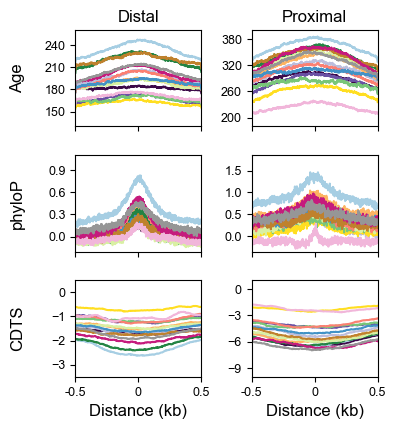

In [58]:
# test = True
test = False
hue_order = ts
palette = [cdict[t] for t in ts]
ylims = {"distal": [[130, 260], [-0.2, 1.1], [-3.5, 0.5]],
		 "proximal": [[180, 400], [-0.35, 1.85], [-10, 1]]
		}
yticks = {"distal": [[150, 180, 210, 240], [0, 0.3, 0.6, 0.9], [-3, -2, -1, 0]],
		  "proximal": [[200, 260, 320, 380], [0, 0.5, 1, 1.5], [-9, -6, -3, 0]]
		 }
outputfile = f"{PROJECT_DIR_o2}figures/ExtDataFig3d.pdf"
generate_metaplot(df_metaplots2, ylims, yticks, test, outputfile, hue_order, palette, (3.9,4.5), False)